# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import glob

# Additional Imports
import os, json, math, time
import tmdbsimple as tmdb
from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

# Custom Functions

In [2]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [3]:
def get_movie_with_rating(movie_id):
    """Copied from Coding Dojo Learning Platform"""
    # Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    # save the .info .releases dictionaries
    info = movie.info()
    releases = movie.releases()
    # Loop through countries in releases
    for c in releases['countries']:
        # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
            ## save a "certification" key in the info dict with the certification
            info['certification'] = c['certification']
    
    return info

# Load Data

## Title Basics

In [4]:
basics = pd.read_csv(r"C:\Users\Evan\Documents\Github\IMDB\Data\title_basics.csv.gz")
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0043139,movie,Life of a Beijing Policeman,Wo zhe yi bei zi,0,2013.0,NaN,120,"Drama,History"
2,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
...,...,...,...,...,...,...,...,...,...
81824,tt9914942,movie,Life Without Sara Amat,La vida sense la Sara Amat,0,2019.0,NaN,74,Drama
81825,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019.0,NaN,97,"Comedy,Drama,Fantasy"
81826,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
81827,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"


# API Extraction from TMDB

## Create API Connection

In [5]:
import json
with open('/Users/Evan/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()

dict_keys(['client-id', 'api-key'])

In [6]:
tmdb.API_KEY =  login['api-key']

## Folders to store and keep existing data

In [12]:
FOLDER = 'Data/'
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'title_akas.csv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_2011.json',
 'tmdb_api_results_2012.json',
 'tmdb_api_results_2013.json',
 'tmdb_api_results_2014.json',
 'tmdb_api_results_2015.json',
 'tmdb_api_results_2016.json',
 'tmdb_api_results_2017.json',
 'tmdb_api_results_2018.json',
 'tmdb_api_results_2019.json',
 'tmdb_api_results_2020.json',
 'tmdb_api_results_2021.json',
 'tmdb_api_results_2022.json',
 'tmdb_results_combined.csv.gz']

## Specify range of years to pull with API

In [13]:
YEARS_TO_GET = range(2010, 2023)
errors = []

In [14]:
"""Adapted from Coding Dojo Learning Platform"""
#START OF OUTER LOOP
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'

    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)

    #Saving new year as the current df
    #Filter for basics df for only specific year
    df = basics[basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    
    ###Stop gap measure to insure previously retrieved data isn't retrieved again
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)

    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    
#INNER LOOP
    
    #Get index and movie id from list
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve the data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)

        except Exception as e:
            errors.append([movie_id, e])
#END OF INNER LOOP
    
#SECOND PART OF OUTERLOOP
    
    #save file as .csv.gz  
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", 
                         compression="gzip", index=False)

# print number of errors
print(f"- Total errors: {len(errors)}")

YEARS:   0%|          | 0/13 [00:00<?, ?it/s]

Movies from 2010:   0%|          | 0/1141 [00:00<?, ?it/s]

Movies from 2011:   0%|          | 0/1213 [00:00<?, ?it/s]

Movies from 2012:   0%|          | 0/1206 [00:00<?, ?it/s]

Movies from 2013:   0%|          | 0/1165 [00:00<?, ?it/s]

Movies from 2014:   0%|          | 0/1160 [00:00<?, ?it/s]

Movies from 2015:   0%|          | 0/1227 [00:00<?, ?it/s]

Movies from 2016:   0%|          | 0/2991 [00:00<?, ?it/s]

Movies from 2017:   0%|          | 0/5640 [00:00<?, ?it/s]

Movies from 2018:   0%|          | 0/5780 [00:00<?, ?it/s]

Movies from 2019:   0%|          | 0/5876 [00:00<?, ?it/s]

Movies from 2020:   0%|          | 0/5005 [00:00<?, ?it/s]

Movies from 2021:   0%|          | 0/5154 [00:00<?, ?it/s]

Movies from 2022: 0it [00:00, ?it/s]

- Total errors: 13702


In [17]:
## Use Glob to Combine Files from 2010 to 2023
q = "Data/final_tmdb_data_*.csv.gz"
chunked_files = glob.glob(q)
# Showing the first 5
files_to_get = chunked_files[2:]
files_to_get

['Data\\final_tmdb_data_2010.csv.gz',
 'Data\\final_tmdb_data_2011.csv.gz',
 'Data\\final_tmdb_data_2012.csv.gz',
 'Data\\final_tmdb_data_2013.csv.gz',
 'Data\\final_tmdb_data_2014.csv.gz',
 'Data\\final_tmdb_data_2015.csv.gz',
 'Data\\final_tmdb_data_2016.csv.gz',
 'Data\\final_tmdb_data_2017.csv.gz',
 'Data\\final_tmdb_data_2018.csv.gz',
 'Data\\final_tmdb_data_2019.csv.gz',
 'Data\\final_tmdb_data_2020.csv.gz',
 'Data\\final_tmdb_data_2021.csv.gz',
 'Data\\final_tmdb_data_2022.csv.gz']

In [18]:
## Loading all files as df and appending to a list
df_list = []
for file in files_to_get:
    temp_df = pd.read_csv(file, index_col=0)
    df_list.append(temp_df)
    
## Concatenating the list of dfs into 1 combined
df_combined = pd.concat(df_list)
df_combined

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",...,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.9,8.0,NaN
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.5,32.0,PG-13
tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",...,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",...,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9896876,0.0,/hMvRbT6HOqERhh3K8kXbaLz9LlZ.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,821493.0,en,India Sweets and Spices,A college freshman confronts her parents’ valu...,...,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Let the aunties talk.,India Sweets and Spices,0.0,6.1,10.0,PG-13
tt9898844,0.0,/q2KFBGyUSzHDhNqXEYv2LqTWVSz.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,870671.0,en,The Hunting,When a mysterious animal attack leaves a mutil...,...,0.0,91.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Hunger runs deep.,The Hunting,0.0,4.7,34.0,NaN
tt9900940,0.0,/3jjWLg5bevWqReyVroYqxwVrH0k.jpg,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,861294.0,en,The Scrapper,"Ex-con turned ""scrapper"" Jake leads a quiet li...",...,0.0,87.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,You can't escape your past.,The Scrapper,0.0,6.0,2.0,NaN


In [19]:
df_combined.drop(index=0, inplace=True)
df_combined.drop(index='0', inplace=True)
df_combined

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",...,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.900,8.0,NaN
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.500,32.0,PG-13
tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",...,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.000,1.0,NaN
tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",...,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.000,5.0,NaN
tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,...,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.595,10366.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9895024,0.0,/S1kutYyoyuBJKGS0mXxv2fZNbr.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,834443.0,de,Heikos Welt,A son tries to save his mother's eyesight by d...,...,0.0,118.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Heiko's World,0.0,6.375,4.0,NaN
tt9896876,0.0,/hMvRbT6HOqERhh3K8kXbaLz9LlZ.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,821493.0,en,India Sweets and Spices,A college freshman confronts her parents’ valu...,...,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Let the aunties talk.,India Sweets and Spices,0.0,6.100,10.0,PG-13
tt9898844,0.0,/q2KFBGyUSzHDhNqXEYv2LqTWVSz.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,870671.0,en,The Hunting,When a mysterious animal attack leaves a mutil...,...,0.0,91.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Hunger runs deep.,The Hunting,0.0,4.700,34.0,NaN


### Clean Groups
- Will change:
 - PG-13 with extra white space to PG-13
 - 10 to G
 - Unrated to NR

In [20]:
df_combined['certification'].value_counts()

R          3657
NR         2846
PG-13      2027
PG          949
G           319
NC-17       120
Unrated       4
PG-13         1
10            1
Name: certification, dtype: int64

In [21]:
df_combined['certification'] = df_combined['certification'].str.replace('10', 'PG')
df_combined['certification'] = df_combined['certification'].str.replace('PG-13 ', 'PG-13')
df_combined['certification'] = df_combined['certification'].str.replace('Unrated', 'NR')
df_combined['certification'].value_counts()

R        3657
NR       2850
PG-13    2028
PG        950
G         319
NC-17     120
Name: certification, dtype: int64

# Hypothesis Testing

## Question 1: Does the MPAA(G/PG/PG-13/R) rating of a movie affect how much revenue the movie generates?

### Step 1: State Null/Alternative Hypothesis

- **Null Hypothesis:** The movie rating does not affect how much revenue a movie generates


- **Alternative Hypothesis:** The movie ratings have a significant affect on how much revenue a movie generates


- **Alpha:** .05

### Step 2: Type of Test

- **ANOVA**
 - Comparing numeric data: revenue
 - More than 2 groups: G, PG, PG-13, R

In [22]:
df1 = df_combined.copy()

#### We should drop the movies with ratings of NR and NC-17 as were are not dealing with these ratings

In [23]:
df1 = df1[(df1['certification'] != 'NR') & (df1['certification'] != 'NC-17')]
df1['certification'].value_counts()

R        3657
PG-13    2028
PG        950
G         319
Name: certification, dtype: int64

#### Separate into groups based on rating

In [24]:
groups = {}
## Loop through all unique categories
for i in df1['certification'].unique():
    ## Get series for group and rename
    data = df1.loc[df1['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys([nan, 'PG-13', 'PG', 'R', 'G'])

In [25]:
# Code from https://stackoverflow.com/questions/24068306/
# is-there-a-way-to-remove-nan-from-a-dictionary-filled-with-data
# Raghul Raj
groups = {k: groups[k] for k in groups if not pd.isna(k)}

In [26]:
groups.keys()


dict_keys(['PG-13', 'PG', 'R', 'G'])

### Step 3: Assumptions
- No significant outliers
- Normality
- Equal Variance

#### Outliers

In [27]:
for i in groups:
    print(f'{i} - Number of rows: {len(groups[i])}')
    z_score = stats.zscore(groups[i])
    outliers = abs(z_score)>3
    print(f'{i} - Number of outliers: {np.sum(outliers)}')
    
    groups[i] = groups[i][~outliers]
    print(f'{i} - Number of rows: {len(groups[i])}')
    print('')

PG-13 - Number of rows: 2028
PG-13 - Number of outliers: 58
PG-13 - Number of rows: 1970

PG - Number of rows: 950
PG - Number of outliers: 24
PG - Number of rows: 926

R - Number of rows: 3657
R - Number of outliers: 77
R - Number of rows: 3580

G - Number of rows: 319
G - Number of outliers: 7
G - Number of rows: 312



#### Normality
- The groups all have > 15 samples

In [28]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
PG-13,1970.0,2.748827e-310,1425.580409
PG,926.0,4.522201e-130,595.654126
R,3580.0,0.000000e+00,2929.261026
G,312.0,1.643048e-97,445.708402


#### Equal Variance

In [29]:
stats.levene(*groups.values())

LeveneResult(statistic=134.0138484466571, pvalue=2.3961909825217307e-84)

### Step 4: Perform Test and Interpret Result
- Since Equal Variance assumption was no met:

 - We will run Kruskal-Wallis test
 
 
- p value < 0.05(alpha), reject Null Hypothesis and support Alternative Hypothesis that movie rating does indeed affect revenue

In [30]:
result_q1 = stats.kruskal( *groups.values())
result_q1

KruskalResult(statistic=193.49340192321637, pvalue=1.0738462829948671e-41)

In [31]:
## is our result significant
print(f"p-value={result_q1.pvalue:.10f}")
print(f"Significant: {result_q1.pvalue <.05}")

p-value=0.0000000000
Significant: True


#### Visualization

In [32]:
groups_df = pd.DataFrame(index=[0], data={'revenue': 0, 'certification':0})
groups_df

,revenue,certification
0,0,0


In [33]:
groups_df.drop(index=0, inplace=True)
groups_df

,revenue,certification


In [36]:
for i in groups:
    groups_temp = pd.DataFrame(groups[i])
    groups_temp['certification'] = i
    groups_df = pd.concat([groups_df, groups_temp])

groups_df.index.name='imdb_id'
groups_df

,revenue,certification
imdb_id,,
tt0326965,0.0,PG-13
tt0427152,86387857.0,PG-13
tt0429493,177238796.0,PG-13
tt0446029,48000000.0,PG-13
tt0460778,0.0,PG-13
...,...,...
tt15831226,0.0,G
tt6714432,0.0,G
tt7336242,0.0,G


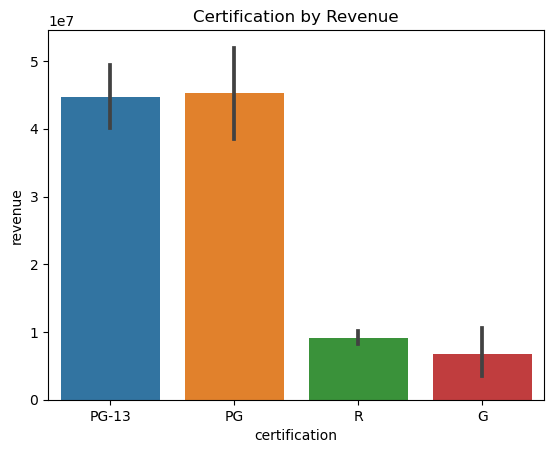

In [37]:
fig, ax = plt.subplots()

ax = sns.barplot(data=groups_df, x=groups_df['certification'], y=groups_df['revenue'])
ax.set_title('Certification by Revenue');

### Step 5: Pairwise Tukey Comparison Test
- Shows 4 significant results
 - reject column
- Reject null hypothesis for groups:
    - G and PG
    - G and PG-13
    - PG and R
    - PG-13 and R
- There is a significant difference in the results of Ratings PG and PG-13 compared to the other 2 ratings
- PG and PG-13 show the most revenue

In [38]:
values = groups_df['revenue']
labels = groups_df['certification']

In [39]:
tukey_q1 = pairwise_tukeyhsd(values, labels)
tukey_q1.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,38556163.1907,0.0,26292557.3172,50819769.0641,True
G,PG-13,37934038.4194,0.0,26518719.1459,49349357.6928,True
G,R,2473690.6141,0.9396,-8585115.8634,13532497.0915,False
PG,PG-13,-622124.7713,0.9965,-8086635.1309,6842385.5882,False
PG,R,-36082472.5766,0.0,-42989469.138,-29175476.0152,True
PG-13,R,-35460347.8053,0.0,-40715829.3812,-30204866.2294,True


## Question 2: Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long or less

### Step 1: State Null/Alternative Hypothesis
- Null Hypothesis: there is no difference in earned revenue between movies that are over 2.5 hours long and movies that are 1.5 hours long (or less)

- Alternative Hypothesis: there is a difference in earned revenue between movies that are over 2.5 hours long and movies that are 1.5 hours long (or less)

- Alpha: 0.05

### Step 2: Type of Test
- Independent T-test:
 - Comparing numeric data: revenue
 - Comparing 2 samples: movies that are over 2.5 hours long and movies that are 1.5 hours (or less) long


#### Create 2 Groups of Data

In [40]:
# long_movie
long_movie = df_combined[df_combined['runtime'] >= 150]
long_movie

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0403645,0.0,/bQ1vPhjXt2DQetGOJVF1gxzilDD.jpg,"{'id': 23170, 'name': 'Burnt by the Sun Trilog...",55000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.predstoyanie.ru/,38318.0,ru,Утомлённые солнцем 2: Предстояние,"Epic film about WWII, a sequel to Utomlyonnye ...",...,0.0,180.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",Released,NaN,Burnt by the Sun 2: Exodus,0.0,5.200,40.0,NaN
tt1182884,0.0,NaN,NaN,5600000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,29888.0,hi,दुल्हा मिल गया,"A man, the heir to an empire, believes that ma...",...,2700000.0,152.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Dulha Mil Gaya,0.0,5.200,28.0,PG
tt1185412,0.0,/vz1D3veOdcvwrA21iIkmamhxMa2.jpg,NaN,1250000.0,"[{'id': 28, 'name': 'Action'}, {'id': 10749, '...",NaN,30886.0,hi,वीर,A Pindari Prince goes to England to study mili...,...,0.0,160.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Veer,0.0,5.200,40.0,NaN
tt1188996,0.0,/fpgSkuEG2eV9nOHAYzqfOg1R8t2.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,26022.0,hi,My Name Is Khan,"Rizwan Khan, a Muslim from the Borivali sectio...",...,42345360.0,165.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"An Ordinary Man, An Extraordinary Journey ... ...",My Name Is Khan,0.0,8.050,1171.0,PG-13
tt1264889,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,110936.0,sr,Kao rani mraz,An Early Frost (Serbian: Kao Rani Mraz) is a S...,...,0.0,168.0,"[{'english_name': 'Serbian', 'iso_639_1': 'sr'...",Released,NaN,An Early Frost,0.0,3.800,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9389998,0.0,/2f9YnS7JKrIqBv7dMQG8sRS2aJv.jpg,"{'id': 921781, 'name': 'Pushpa Collection', 'p...",0.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,690957.0,te,పుష్పా - The Rise,Pushpa Raj is a coolie who rises in the world ...,...,0.0,179.0,"[{'english_name': 'Telugu', 'iso_639_1': 'te',...",Released,NaN,Pushpa: The Rise - Part 1,0.0,7.274,84.0,NaN
tt9537936,0.0,NaN,NaN,500000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://www.redifilms.com,583631.0,hi,Tank Cleaner,A young orphan boy working as a tank cleaner i...,...,0.0,157.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,Suspense Thriller,Tank Cleaner,0.0,9.000,3.0,NaN
tt9592496,0.0,/zDI8OZTmLbzNgKi060u3bk5UPV0.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}]",NaN,788106.0,kn,ಪೊಗರು,"Shiva, a ruffian, is the terror of his area in...",...,0.0,160.0,"[{'english_name': 'Kannada', 'iso_639_1': 'kn'...",Released,NaN,Pogaru,0.0,3.000,1.0,NaN


In [41]:
# short movie
short_movie = df_combined[df_combined['runtime'] <= 90]
short_movie

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",...,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.9,8.0,NaN
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.5,32.0,PG-13
tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",...,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
tt0437462,0.0,NaN,NaN,0.0,[],NaN,339046.0,fr,"Cargo, les hommes perdus",NaN,...,0.0,0.0,[],Released,NaN,"Cargo, the Lost Men",0.0,0.0,0.0,NaN
tt0454155,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://elhadabuenapelicula.blogspot.com/,580560.0,es,El hada buena - Una fábula peronista,In a popular auction that matches the sinister...,...,0.0,85.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,She came from far away. She was blond. She was...,El hada buena - Una fábula peronista,0.0,5.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9873652,0.0,/iVAZeGHmnV8JdjxMhEwAvetySwf.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,729793.0,de,Ein nasser Hund,"Based on a provocative autobiography, this sto...",...,0.0,0.0,[],Released,NaN,Wet Dog,0.0,6.9,7.0,NaN
tt9890120,0.0,/7sLtpZZb3ErdHxmtUKIkmuuEtcR.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,688616.0,it,Resurrection Corporation,Caligari is a famous undertaker who’s been on ...,...,0.0,0.0,"[{'english_name': 'Italian', 'iso_639_1': 'it'...",Released,The Reaper has never been cheaper,Resurrection Corporation,0.0,6.9,5.0,NaN
tt9892604,0.0,NaN,"{'id': 977876, 'name': 'The Tribunal Collectio...",0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,788854.0,en,Divine Decision: Double Down,The seven-year-itch hits the marriage of Joe a...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Their love still depends on it.,Divine Decision: Double Down,0.0,4.0,4.0,NaN


In [42]:
long_revenue = long_movie['revenue']
short_revenue = short_movie['revenue']

### Step 3: Assumptions

#### Outliers

In [43]:
# long revenue
zscores_long = stats.zscore(long_revenue)
outliers_long = abs(zscores_long)>3
print(f'Len: {len(long_revenue)}')
print(f'Number of Ouliers: {np.sum(outliers_long)}')

long_revenue = long_revenue[~outliers_long]
print(f'Len: {len(long_revenue)}')

Len: 906
Number of Ouliers: 14
Len: 892


In [44]:
# short revenue
zscores_short = stats.zscore(short_revenue)
outliers_short = abs(zscores_short)>3
print(f'Len: {len(short_revenue)}')
print(f'Number of Ouliers: {np.sum(outliers_short)}')

short_revenue = short_revenue[~outliers_short]
print(f'Len: {len(short_revenue)}')

Len: 20603
Number of Ouliers: 102
Len: 20501


#### Normality
- Since both groups have sample count > 15, can skip this step entirely

#### Equal Variance
- Equal Variance assumption is not met
- Will add equal_var = False to test

In [45]:
stats.levene(long_revenue, short_revenue)

LeveneResult(statistic=935.8081849816117, pvalue=3.439011133363739e-201)

### Step 4: Perform Test & Interpret Result
- p value < .05, reject null hypothesis and support alternative hypothesis


- Runtime length does not affect revenue

In [46]:
result_q2 = stats.ttest_ind(long_revenue, short_revenue, equal_var=False)
result_q2

Ttest_indResult(statistic=6.451738202403839, pvalue=1.8122880164761165e-10)

In [47]:
## is our result significant
print(f"p-value={result_q2.pvalue:.10f}")
print(f"Significant: {result_q2.pvalue <.05}")

p-value=0.0000000002
Significant: True


### Visualization

In [50]:
long_df = pd.DataFrame(long_revenue)
long_df['runtime'] = 'long'
long_df

,revenue,runtime
imdb_id,,
tt0403645,0.0,long
tt1182884,2700000.0,long
tt1185412,0.0,long
tt1188996,42345360.0,long
tt1264889,0.0,long
...,...,...
tt9389998,0.0,long
tt9537936,0.0,long
tt9592496,0.0,long


In [51]:
short_df = pd.DataFrame(short_revenue)
short_df['runtime'] = 'short'
short_df

,revenue,runtime
imdb_id,,
tt0312305,0.0,short
tt0326965,0.0,short
tt0331312,0.0,short
tt0437462,0.0,short
tt0454155,0.0,short
...,...,...
tt9873652,0.0,short
tt9890120,0.0,short
tt9892604,0.0,short


In [52]:
plot_q2 = pd.concat([long_df, short_df])
plot_q2

,revenue,runtime
imdb_id,,
tt0403645,0.0,long
tt1182884,2700000.0,long
tt1185412,0.0,long
tt1188996,42345360.0,long
tt1264889,0.0,long
...,...,...
tt9873652,0.0,short
tt9890120,0.0,short
tt9892604,0.0,short


In [54]:
print(f'Long Movie Revenue: {long_revenue.mean():,.2f}')
print(f'Short Movie Revenue: {short_revenue.mean():,.2f}')

Long Movie Revenue: 11,083,215.44
Short Movie Revenue: 145,429.74


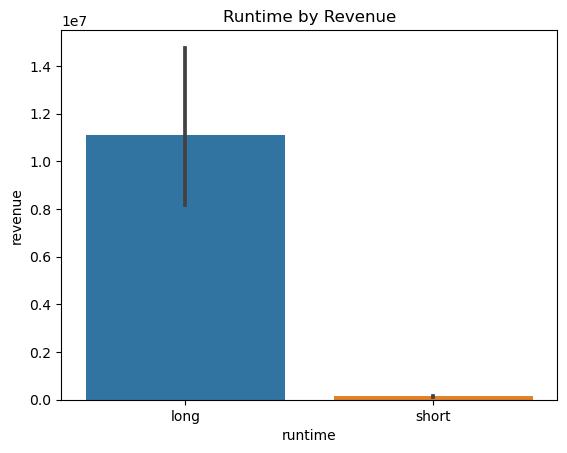

In [55]:
fig, ax = plt.subplots()

ax = sns.barplot(data=plot_q2, x='runtime', y='revenue')
ax.set_title('Runtime by Revenue');

## Question 3: Do some movies genres earn more revenue than others?

#### Extract Genre Column

In [56]:
df_q3 = df_combined.copy()

In [57]:
df_q3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46296 entries, tt0312305 to tt9907782
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  46296 non-null  float64
 1   backdrop_path          31620 non-null  object 
 2   belongs_to_collection  2962 non-null   object 
 3   budget                 46296 non-null  float64
 4   genres                 46296 non-null  object 
 5   homepage               12380 non-null  object 
 6   id                     46296 non-null  float64
 7   original_language      46296 non-null  object 
 8   original_title         46296 non-null  object 
 9   overview               45383 non-null  object 
 10  popularity             46296 non-null  float64
 11  poster_path            43352 non-null  object 
 12  production_companies   46296 non-null  object 
 13  production_countries   46296 non-null  object 
 14  release_date           45508 non-null  object 


In [58]:
print(type(df_q3['genres'][0]))
print(df_q3['genres'][0])

<class 'str'>
[{'id': 10751, 'name': 'Family'}, {'id': 16, 'name': 'Animation'}, {'id': 878, 'name': 'Science Fiction'}]


In [59]:
# function to replace single quotes to double quotes, for use with json
# apply json.loads to convert object type to list type
# iterate through list to extract 'name' from dict
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [60]:
df_q3['genres_list'] = df_q3['genres'].apply(get_genre_name)
df_q3_explode = df_q3.explode('genres_list')
df_q3_explode.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,genres_list
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",...,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.9,8.0,NaN,Family
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",...,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.9,8.0,NaN,Animation
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",...,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.9,8.0,NaN,Science Fiction
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",...,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.5,32.0,PG-13,Thriller
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",...,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.5,32.0,PG-13,Mystery


In [61]:
cols_to_make = df_q3_explode['genres_list'].dropna().unique()
cols_to_make

array(['Family', 'Animation', 'Science Fiction', 'Thriller', 'Mystery',
       'Drama', 'Romance', 'Comedy', 'War', 'Crime', 'Action',
       'Adventure', 'Horror', 'Fantasy', 'History', 'Western', 'Music',
       'Documentary', 'TV Movie'], dtype=object)

In [62]:
pd.set_option('display.max_columns', None)

In [63]:
for col in cols_to_make:
    df_q3[col] = df_q3['genres'].str.contains(col)
df_q3.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,genres_list,Family,Animation,Science Fiction,Thriller,Mystery,Drama,Romance,Comedy,War,Crime,Action,Adventure,Horror,Fantasy,History,Western,Music,Documentary,TV Movie
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.307,/uneDCn8y6RHKc5IAfpgznmaan9I.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.900,8.0,NaN,"[Family, Animation, Science Fiction]",True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",2.868,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.500,32.0,PG-13,"[Thriller, Mystery, Drama]",False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.000,1.0,NaN,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",1.607,/2j90os0c2HJuIjWXxMg9vMvOliw.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.000,5.0,NaN,"[Romance, Comedy, Drama]",False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,110.926,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tzsMJBJZINu7GHzrp...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.595,10366.0,PG,"[Animation, Family]",True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [64]:
# remove original 'genres' column
df_q3.drop(columns='genres', inplace=True)
df_q3.head(1)

,adult,backdrop_path,belongs_to_collection,budget,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,genres_list,Family,Animation,Science Fiction,Thriller,Mystery,Drama,Romance,Comedy,War,Crime,Action,Adventure,Horror,Fantasy,History,Western,Music,Documentary,TV Movie
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.307,/uneDCn8y6RHKc5IAfpgznmaan9I.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.9,8.0,NaN,"[Family, Animation, Science Fiction]",True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


#### Separate Groups

In [65]:
groups_q3 = {}
## Loop through all unique categories
for i in df_q3.columns[26:]:
    ## Get series for group and rename
    data = df_q3.loc[df_q3[i],'revenue'].copy()
    
    # save into the dictionary
    groups_q3[i] = data
groups_q3.keys()

dict_keys(['Animation', 'Science Fiction', 'Thriller', 'Mystery', 'Drama', 'Romance', 'Comedy', 'War', 'Crime', 'Action', 'Adventure', 'Horror', 'Fantasy', 'History', 'Western', 'Music', 'Documentary', 'TV Movie'])

### STEP 1: State Null/Alternative Hypothesis

- **Null Hypothesis:** there is no difference in earned revenue between movie genres


- **Alternative Hypothesis:** there is a difference in earned revenue between movie genres


- **Alpha:** 0.05

### Step 2: Type of Test
- ANOVA
 - Comparing numeric data: revenue
 - More than 2 groups. 19 in total
 - Numeric data with more than 2 groups is ANOVA test

In [66]:
len(cols_to_make)

19

### Step 3: Assumptions
- No significant outliers
- Normality
- Equal Variance

#### Outliers

In [67]:
for i in groups_q3:
    print(f'{i} - Number of rows: {len(groups_q3[i])}')
    z_score = stats.zscore(groups_q3[i])
    outliers = abs(z_score)>3
    print(f'{i} - Number of outliers: {np.sum(outliers)}')
    
    groups_q3[i] = groups_q3[i][~outliers]
    print(f'{i} - Number of rows: {len(groups_q3[i])}')
    print('')

Animation - Number of rows: 1616
Animation - Number of outliers: 44
Animation - Number of rows: 1572

Science Fiction - Number of rows: 2565
Science Fiction - Number of outliers: 49
Science Fiction - Number of rows: 2516

Thriller - Number of rows: 8336
Thriller - Number of outliers: 92
Thriller - Number of rows: 8244

Mystery - Number of rows: 2461
Mystery - Number of outliers: 45
Mystery - Number of rows: 2416

Drama - Number of rows: 22026
Drama - Number of outliers: 191
Drama - Number of rows: 21835

Romance - Number of rows: 5588
Romance - Number of outliers: 56
Romance - Number of rows: 5532

Comedy - Number of rows: 11864
Comedy - Number of outliers: 154
Comedy - Number of rows: 11710

War - Number of rows: 735
War - Number of outliers: 10
War - Number of rows: 725

Crime - Number of rows: 3459
Crime - Number of outliers: 41
Crime - Number of rows: 3418

Action - Number of rows: 5153
Action - Number of outliers: 100
Action - Number of rows: 5053

Adventure - Number of rows: 2401

#### Normality
- Group sample sizes > 20
- Assume normality with higher sample sizes

#### Equal Variance

In [68]:
stats.levene(*groups_q3.values())

LeveneResult(statistic=228.26701442368218, pvalue=0.0)

- the resulting p value is less than .05 which means we should run a Kruskal-Wallis test

### Step 4: Perform Test & Interpret Results

#### Kruskal-Wallis Test

In [69]:
result_q3 = stats.kruskal( *groups_q3.values())
result_q3

KruskalResult(statistic=1921.507878400108, pvalue=0.0)

- Our p value is less than .05 which means we reject our null hypothesis and support alternative hypothesis
- There is a difference in revenue across movie genres

In [70]:
## is our result significant
print(f"p-value={result_q3.pvalue:.10f}")
print(f"Significant: {result_q3.pvalue <.05}")

p-value=0.0000000000
Significant: True


In [71]:
groups_q3_df = pd.DataFrame(index=[0], data={'revenue': 0, 'genres':0})
groups_q3_df

,revenue,genres
0,0,0


In [72]:
for i in groups_q3:
    groups_q3_temp = pd.DataFrame(groups_q3[i])
    groups_q3_temp['genres'] = i
    groups_q3_df = pd.concat([groups_q3_df, groups_q3_temp])

groups_q3_df.index.name='imdb_id'
groups_q3_df

,revenue,genres
imdb_id,,
0,0.0,0
tt0312305,0.0,Animation
tt0765465,0.0,Animation
tt0775489,6007194.0,Animation
tt0811021,0.0,Animation
...,...,...
tt16210710,0.0,TV Movie
tt7435168,0.0,TV Movie
tt8354582,0.0,TV Movie


In [73]:
groups_q3_df.drop(index=0, inplace=True)
groups_q3_df

,revenue,genres
imdb_id,,
tt0312305,0.0,Animation
tt0765465,0.0,Animation
tt0775489,6007194.0,Animation
tt0811021,0.0,Animation
tt0915463,20776.0,Animation
...,...,...
tt16210710,0.0,TV Movie
tt7435168,0.0,TV Movie
tt8354582,0.0,TV Movie


In [74]:
df_agg = groups_q3_df.groupby('genres')['revenue'].mean().sort_values(ascending=False)
df_agg

genres
Adventure          3.430467e+07
Animation          1.406942e+07
Fantasy            1.396218e+07
Action             1.363280e+07
Science Fiction    1.268918e+07
War                5.743683e+06
History            5.394642e+06
Crime              4.215303e+06
Comedy             3.132503e+06
Thriller           2.950889e+06
Western            2.611216e+06
Mystery            2.513693e+06
Romance            2.249255e+06
Music              2.165868e+06
Drama              1.395299e+06
Horror             6.638445e+05
TV Movie           8.540925e+02
Documentary        4.075948e+02
Name: revenue, dtype: float64

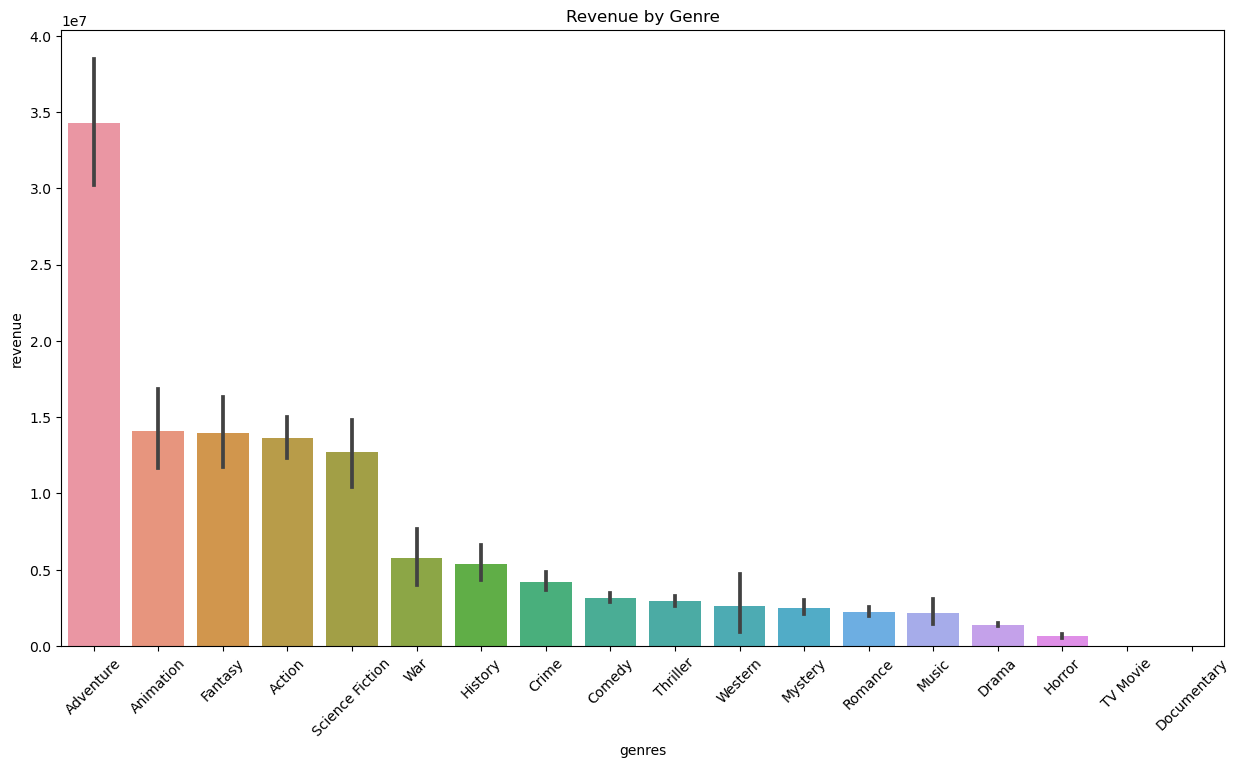

In [75]:
fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.barplot(data=groups_q3_df, x='genres', y='revenue',
                order=df_agg.index)
ax.set_title('Revenue by Genre')

plt.xticks(rotation=45);

### Step 5: Perform Pairwise Tukey Comparison Test
- The adventure genre has the most significant difference

In [76]:
values_q3 = groups_q3_df['revenue']
labels_q3 = groups_q3_df['genres']

In [77]:
tukey_q3 = pairwise_tukeyhsd(values_q3, labels_q3)
tukey_q3.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Action,Adventure,20671862.6894,0.0,18085941.1025,23257784.2763,True
Action,Animation,436617.397,1.0,-2544314.3533,3417549.1472,False
Action,Comedy,-10500300.9139,0.0,-12237632.787,-8762969.0408,True
Action,Crime,-9417500.6279,0.0,-11703450.3492,-7131550.9066,True
Action,Documentary,-13632396.213,0.0,-19352880.9212,-7911911.5048,True
Action,Drama,-12237504.3477,0.0,-13848847.4114,-10626161.284,True
Action,Fantasy,329371.3969,1.0,-2352794.4032,3011537.1971,False
Action,History,-8238162.0045,0.0,-11623787.9493,-4852536.0597,True
Action,Horror,-12968959.3308,0.0,-14867440.1332,-11070478.5284,True
Action,Music,-11466935.334,0.0,-15080563.8598,-7853306.8083,True


#### Tukey Dataframe with reject being true

In [78]:
tukey_df = pd.DataFrame(tukey_q3.summary().data)
tukey_df

,0,1,2,3,4,5,6
0,group1,group2,meandiff,p-adj,lower,upper,reject
1,Action,Adventure,20671862.6894,0.0,18085941.1025,23257784.2763,True
2,Action,Animation,436617.397,1.0,-2544314.3533,3417549.1472,False
3,Action,Comedy,-10500300.9139,0.0,-12237632.787,-8762969.0408,True
4,Action,Crime,-9417500.6279,0.0,-11703450.3492,-7131550.9066,True
...,...,...,...,...,...,...,...
149,TV Movie,War,5742829.393,0.3374,-1510490.617,12996149.403,False
150,TV Movie,Western,2610362.1261,0.9999,-5885109.8249,11105834.0772,False
151,Thriller,War,2792794.6473,0.5794,-1205677.0716,6791266.3663,False
152,Thriller,Western,-339672.6195,1.0,-6302068.8317,5622723.5926,False


In [79]:
tukey_df.columns = tukey_df.iloc[0]
tukey_df.columns

Index(['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], dtype='object', name=0)

In [80]:
tukey_df.drop(index=0, inplace=True)
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Action,Adventure,20671862.6894,0.0,18085941.1025,23257784.2763,True
2,Action,Animation,436617.397,1.0,-2544314.3533,3417549.1472,False
3,Action,Comedy,-10500300.9139,0.0,-12237632.787,-8762969.0408,True
4,Action,Crime,-9417500.6279,0.0,-11703450.3492,-7131550.9066,True
5,Action,Documentary,-13632396.213,0.0,-19352880.9212,-7911911.5048,True
...,...,...,...,...,...,...,...
149,TV Movie,War,5742829.393,0.3374,-1510490.617,12996149.403,False
150,TV Movie,Western,2610362.1261,0.9999,-5885109.8249,11105834.0772,False
151,Thriller,War,2792794.6473,0.5794,-1205677.0716,6791266.3663,False
152,Thriller,Western,-339672.6195,1.0,-6302068.8317,5622723.5926,False


In [81]:
tukey_df_true = tukey_df[tukey_df['reject'] == True]
tukey_df_true

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Action,Adventure,20671862.6894,0.0,18085941.1025,23257784.2763,True
3,Action,Comedy,-10500300.9139,0.0,-12237632.787,-8762969.0408,True
4,Action,Crime,-9417500.6279,0.0,-11703450.3492,-7131550.9066,True
5,Action,Documentary,-13632396.213,0.0,-19352880.9212,-7911911.5048,True
6,Action,Drama,-12237504.3477,0.0,-13848847.4114,-10626161.284,True
...,...,...,...,...,...,...,...
139,Romance,Science Fiction,10439928.1287,0.0,7957894.9011,12921961.3562,True
144,Science Fiction,TV Movie,-12688329.4472,0.0,-19180617.2868,-6196041.6076,True
145,Science Fiction,Thriller,-9738294.7016,0.0,-12089236.2814,-7387353.1217,True
146,Science Fiction,War,-6945500.0542,0.0,-11296361.019,-2594639.0894,True


In [82]:
tukey_df_true['group1'].value_counts()

Adventure          16
Action             14
Animation          13
Fantasy             9
Drama               5
Comedy              4
Crime               4
Science Fiction     4
Horror              3
Documentary         2
History             2
Music               1
Mystery             1
Romance             1
Name: group1, dtype: int64